In [16]:
import pandas as pd
import numpy as np
from taigapy import create_taiga_client_v3
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.multicomp import multipletests
from statannotations.Annotator import Annotator

# Import data

In [17]:
tc= create_taiga_client_v3()

In [18]:
crispr_dependencies = pd.read_pickle("pydata/tfs_dependencies.pkl")
Model = pd.read_pickle("pydata/model_data.pkl")

In [19]:
crispr_dependencies.fillna(0, inplace=True)

In [20]:
OmicsFusionFiltered = tc.get(name='internal-24q4-8c04', version=117, file='OmicsFusionFiltered')

In [21]:
OmicsFusionFiltered.LeftGene = OmicsFusionFiltered.LeftGene.map(lambda x: x.split(' ')[0])
OmicsFusionFiltered.RightGene = OmicsFusionFiltered.RightGene.map(lambda x: x.split(' ')[0])

In [22]:
OmicsFusionFiltered.to_pickle("pydata/OmcisFusionFiltered.pkl")

# Look at distribution of CRISPR dependencies among left vs. right genes in translocations

In [23]:
# find only TFs also found in dependencies dataset
left_gene_common_tfs = [tf for tf in OmicsFusionFiltered.LeftGene if tf in crispr_dependencies.columns]
right_gene_common_tfs = [tf for tf in OmicsFusionFiltered.RightGene if tf in crispr_dependencies.columns]

In [24]:
# filter crispr_dependencies to include only TFs also found in fusions
crispr_dependencies_tfs = crispr_dependencies.loc[:, list(set(left_gene_common_tfs + right_gene_common_tfs))]

In [25]:
crispr_dependencies_tfs

,EEA1,SMAD9,ZNF132,ZNF552,FOXK1,TEF,ZFP62,PLSCR1,POU3F3,ZNF107,...,ZBTB22,NR2C1,ZNF257,ZFPM2,ZNF93,BHLHE40,TFAP2B,PAX3,ZNF737,NRL
ACH-000001,-0.069710,-0.001885,-0.175808,-0.132973,-0.086270,-0.280875,0.020941,0.146788,-0.047075,0.071604,...,-0.017070,-0.085688,0.128262,0.165973,-0.005436,0.096073,-0.052657,0.075894,-0.238080,-0.077019
ACH-000004,-0.014762,-0.070265,-0.029821,0.168278,0.019695,-0.064289,-0.071765,0.066783,0.032054,0.042658,...,-0.223275,-0.039167,0.094398,0.003317,0.000272,-0.016701,0.066916,0.067833,0.296707,-0.290564
ACH-000005,-0.250621,-0.028326,-0.202843,-0.081631,-0.258287,0.054423,0.019080,-0.033936,-0.123952,-0.017083,...,-0.134172,-0.535239,-0.118274,0.051770,-0.266481,0.109019,-0.361703,0.365530,-0.061971,0.200085
ACH-000007,-0.085731,-0.078039,-0.072576,0.108544,-0.042336,0.022804,0.204431,0.065412,-0.069215,-0.103847,...,0.120294,-0.124109,0.045210,0.037941,0.033505,0.205046,0.200249,0.034331,-0.140029,0.046336
ACH-000009,0.113557,0.051688,-0.126593,0.148441,0.162418,-0.150908,-0.050357,-0.054079,0.063808,-0.072832,...,-0.104761,-0.276744,-0.090029,-0.019436,-0.282499,0.206604,-0.001485,-0.183486,-0.131327,0.047954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-003578,0.007599,0.100464,-0.224928,0.048301,-0.275130,-0.144781,0.213009,0.140247,0.109625,0.082337,...,-0.120644,-0.054484,-0.151990,-0.021366,0.022710,0.037176,-0.033106,0.027015,0.235187,-0.010233
ACH-003580,0.207531,0.153572,-0.063495,-0.040055,-0.096836,-0.236410,0.072548,0.126320,0.095534,0.219512,...,0.000593,-0.095610,-0.107608,-0.004420,0.176697,0.013722,-0.181257,0.069443,0.328346,0.026322
ACH-003587,0.118366,0.163463,-0.181378,-0.152047,-0.147100,-0.417124,0.180036,0.000845,-0.041296,0.379420,...,-0.098498,-0.464936,0.046546,-0.113956,-0.010909,-0.151759,-0.347200,-0.163843,0.202594,-0.028970
ACH-003590,-0.036525,0.129469,-0.092806,-0.020125,-0.279096,-0.274629,0.119142,0.123074,0.083703,0.059119,...,-0.037169,-0.235942,0.078806,-0.105341,0.000003,0.106948,-0.090314,0.021431,0.166902,0.004454


In [26]:
# merge crispr_dependencies with cell line information based on ModelID (index in crispr_dependencies)
crispr_dependencies_tfs_merge = crispr_dependencies_tfs.merge(Model[['ModelID', 'CellLineName', "OncotreeLineage", "OncotreeSubtype", "PrimaryOrMetastasis"]], left_index = True, right_on = 'ModelID')

In [27]:
crispr_dependencies_tfs_merge = crispr_dependencies_tfs_merge.melt(value_vars = set(left_gene_common_tfs + right_gene_common_tfs), id_vars= ['ModelID', 'CellLineName', "OncotreeLineage", "OncotreeSubtype", "PrimaryOrMetastasis"],
                                                    var_name = "TF", value_name = "Depmap_score")

In [28]:
crispr_dependencies_tfs_merge

,ModelID,CellLineName,OncotreeLineage,OncotreeSubtype,PrimaryOrMetastasis,TF,Depmap_score
0,ACH-000001,NIH:OVCAR-3,Ovary/Fallopian Tube,High-Grade Serous Ovarian Cancer,Metastatic,EEA1,-0.069710
1,ACH-000004,HEL,Myeloid,Acute Myeloid Leukemia,Primary,EEA1,-0.014762
2,ACH-000005,HEL 92.1.7,Myeloid,Acute Myeloid Leukemia,None,EEA1,-0.250621
3,ACH-000007,LS513,Bowel,Colon Adenocarcinoma,Primary,EEA1,-0.085731
4,ACH-000009,C2BBe1,Bowel,Colon Adenocarcinoma,Primary,EEA1,0.113557
...,...,...,...,...,...,...,...
1353773,ACH-003578,ES8_SLFN11-KO,Bone,Ewing Sarcoma,Primary,NRL,-0.010233
1353774,ACH-003580,SJ-DIPGX7,CNS/Brain,Diffuse Intrinsic Pontine Glioma,None,NRL,0.026322
1353775,ACH-003587,531MII,Bone,Osteosarcoma,Metastatic,NRL,-0.028970
1353776,ACH-003590,YCUB-2,Lymphoid,B-Lymphoblastic Leukemia/Lymphoma,Recurrent,NRL,0.004454


In [29]:
leftgene_fusion_dependencies_df = OmicsFusionFiltered.merge(crispr_dependencies_tfs_merge, left_on= ['ModelID', 'LeftGene'], right_on= ['ModelID', 'TF'])
rightgene_fusion_dependencies_df = OmicsFusionFiltered.merge(crispr_dependencies_tfs_merge, left_on= ['ModelID', 'RightGene'], right_on= ['ModelID', 'TF'])

In [30]:
rightgene_fusion_dependencies_df['gene_side'] = "right"
leftgene_fusion_dependencies_df['gene_side']= "left"

In [31]:
concatenated_fusion_dependencies = pd.concat([leftgene_fusion_dependencies_df, rightgene_fusion_dependencies_df])

In [32]:
concatenated_fusion_dependencies

,ModelID,FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,LargeAnchorSupport,...,RightBreakEntropy,annots,CCLE_count,CellLineName,OncotreeLineage,OncotreeSubtype,PrimaryOrMetastasis,TF,Depmap_score,gene_side
0,ACH-001289,PBX3--MAPKAP1,3,1,ONLY_REF_SPLICE,PBX3,chr9:125748623:+,MAPKAP1,chr9:125669907:-,YES_LDAS,...,1.8295,"[""TCGA_StarF2019"",""INTRACHROMOSOMAL[chr9:0.04M...",1,COG-AR-359,CNS/Brain,Atypical Teratoid/Rhabdoid Tumor,None,PBX3,-0.070610,left
1,ACH-000570,DMRTA1--LINC01239,6,3,INCL_NON_REF_SPLICE,DMRTA1,chr9:22467906:+,LINC01239,chr9:22674443:+,YES_LDAS,...,1.9656,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr9:0.19M...",41,YKG1,CNS/Brain,Glioblastoma,Primary,DMRTA1,-0.133092,left
2,ACH-001838,DMRTA1--LINC01239,16,13,INCL_NON_REF_SPLICE,DMRTA1,chr9:22467906:+,LINC01239,chr9:22674443:+,YES_LDAS,...,1.9656,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr9:0.19M...",41,ICC12,Biliary Tract,Intrahepatic Cholangiocarcinoma,Primary,DMRTA1,-0.023106,left
3,ACH-001415,DMRTA1--LINC01239,8,4,INCL_NON_REF_SPLICE,DMRTA1,chr9:22467906:+,LINC01239,chr9:22674443:+,YES_LDAS,...,1.9656,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr9:0.19M...",41,UM-UC7,Bladder/Urinary Tract,Bladder Urothelial Carcinoma,Primary,DMRTA1,-0.201221,left
4,ACH-002077,DMRTA1--LINC01239,3,3,INCL_NON_REF_SPLICE,DMRTA1,chr9:22467906:+,LINC01239,chr9:22674443:+,YES_LDAS,...,1.9656,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr9:0.19M...",41,Lu-165,Lung,Small Cell Lung Cancer,Metastatic,DMRTA1,-0.184038,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,ACH-002709,SMYD3--AHCTF1,7,11,INCL_NON_REF_SPLICE,SMYD3,chr1:246135175:-,AHCTF1,chr1:246916395:-,YES_LDAS,...,1.7819,"[""INTRACHROMOSOMAL[chr1:0.33Mb]""]",1,CMS,Myeloid,Acute Megakaryoblastic Leukemia,None,AHCTF1,-1.456332,right
1613,ACH-003587,YLPM1--ZNF358,103,51,ONLY_REF_SPLICE,YLPM1,chr14:74764362:+,ZNF358,chr19:7519205:+,YES_LDAS,...,1.9656,"[""INTERCHROMOSOMAL[chr14--chr19]""]",1,531MII,Bone,Osteosarcoma,Metastatic,ZNF358,-0.028805,right
1614,ACH-003587,SNAPC1--HIF1A,4,1,ONLY_REF_SPLICE,SNAPC1,chr14:61762588:+,HIF1A,chr14:61720382:+,YES_LDAS,...,1.9329,"[""INTRACHROMOSOMAL[chr14:0.01Mb]"",""LOCAL_REARR...",1,531MII,Bone,Osteosarcoma,Metastatic,HIF1A,0.134081,right
1615,ACH-003186,C9--ZNF131,5,3,ONLY_REF_SPLICE,C9,chr5:39341146:-,ZNF131,chr5:43161249:+,YES_LDAS,...,1.5546,"[""INTRACHROMOSOMAL[chr5:3.64Mb]""]",1,NRH-UPS3,Soft Tissue,Undifferentiated Pleomorphic Sarcoma/Malignant...,Primary,ZNF131,-0.938593,right


In [33]:
concatenated_fusion_dependencies.isnull().sum()

ModelID                  0
FusionName               0
JunctionReadCount        0
SpanningFragCount        0
SpliceType               0
LeftGene                 0
LeftBreakpoint           0
RightGene                0
RightBreakpoint          0
LargeAnchorSupport       0
FFPM                     0
LeftBreakDinuc           0
LeftBreakEntropy         0
RightBreakDinuc          0
RightBreakEntropy        0
annots                   0
CCLE_count               0
CellLineName             0
OncotreeLineage          0
OncotreeSubtype          0
PrimaryOrMetastasis    407
TF                       0
Depmap_score             0
gene_side                0
dtype: int64

<Axes: xlabel='gene_side', ylabel='Depmap_score'>

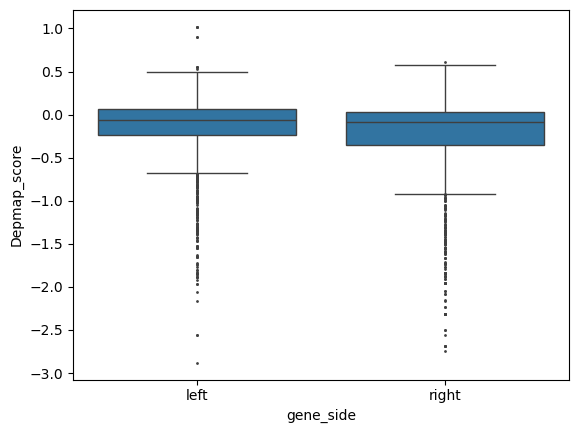

In [34]:
sns.boxplot(concatenated_fusion_dependencies, x = "gene_side" , y = "Depmap_score", fliersize= 1)

# How often are TFs that participate in translocations also a dependency?

In [35]:
# merge crispr_dependencies with cell line information based on ModelID (index in crispr_dependencies)
crispr_dependencies_merge = crispr_dependencies.merge(Model[['ModelID', 'CellLineName', "OncotreeLineage", "OncotreeSubtype", "PrimaryOrMetastasis"]], left_index = True, right_on = 'ModelID')

In [36]:
crispr_dependencies_merge

,TFAP2A,TFAP2B,TFAP2C,TFAP2D,TFAP2E,ARID3A,ARID3B,ARID3C,ARID5A,ARID5B,...,BMAL2,ZNF875,CBLL2,ZUP1,TBXT,ModelID,CellLineName,OncotreeLineage,OncotreeSubtype,PrimaryOrMetastasis
0,0.032275,-0.052657,-0.099978,-0.040024,0.060890,0.102625,-0.121782,0.027268,-0.243864,-0.096952,...,0.140806,-0.892911,0.215270,-0.014496,0.169385,ACH-000001,NIH:OVCAR-3,Ovary/Fallopian Tube,High-Grade Serous Ovarian Cancer,Metastatic
3,0.145169,0.066916,-0.074218,-0.125423,0.240744,-0.105335,-0.734358,-0.027738,-0.136107,0.008301,...,-0.090015,0.168027,0.280951,-0.182743,0.082328,ACH-000004,HEL,Myeloid,Acute Myeloid Leukemia,Primary
4,0.171513,-0.361703,-0.017947,-0.103094,0.315080,0.069369,-0.026263,-0.022071,0.006219,0.200501,...,-0.134599,0.374316,-0.018200,-0.283811,0.058674,ACH-000005,HEL 92.1.7,Myeloid,Acute Myeloid Leukemia,None
6,-0.073170,0.200249,-0.292673,-0.238197,-0.059635,0.041934,-0.329979,-0.080568,-0.067746,-0.198359,...,-0.069550,0.180594,0.104287,-0.311871,-0.006005,ACH-000007,LS513,Bowel,Colon Adenocarcinoma,Primary
8,0.224490,-0.001485,-0.172446,0.018604,0.034670,-0.316335,-0.053869,0.059077,-0.058235,-0.495861,...,0.027901,0.098494,0.060150,0.014514,0.136429,ACH-000009,C2BBe1,Bowel,Colon Adenocarcinoma,Primary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,-0.070363,-0.033106,-0.243238,-0.370448,-0.108596,0.023995,-0.181551,-0.213355,-0.284968,-0.052868,...,-0.106350,0.018423,0.079413,0.005381,0.105370,ACH-003578,ES8_SLFN11-KO,Bone,Ewing Sarcoma,Primary
2516,-0.081792,-0.181257,-0.381345,-0.202155,0.109083,-0.004828,0.018773,-0.112690,-0.071700,-0.386106,...,-0.077457,-0.205756,-0.021425,0.016575,0.077086,ACH-003580,SJ-DIPGX7,CNS/Brain,Diffuse Intrinsic Pontine Glioma,None
2518,-0.128495,-0.347200,-0.229025,-0.420290,0.106401,-0.087998,0.062317,-0.158840,0.009397,-0.086930,...,0.210714,-0.104913,-0.141233,0.058059,0.013758,ACH-003587,531MII,Bone,Osteosarcoma,Metastatic
2520,0.029615,-0.090314,-0.087541,-0.343993,0.073768,-0.087375,-0.049801,-0.047360,0.009253,-0.328680,...,-0.007903,-0.250206,-0.080775,0.102683,0.069626,ACH-003590,YCUB-2,Lymphoid,B-Lymphoblastic Leukemia/Lymphoma,Recurrent


In [37]:
# merge crispr dependencies with model information
crispr_dependencies_merge = crispr_dependencies_merge.melt(value_vars = crispr_dependencies_merge.columns, id_vars= ['ModelID', 'CellLineName', "OncotreeLineage", "OncotreeSubtype", "PrimaryOrMetastasis"],
                                                    var_name = "TF", value_name = "Depmap_score")

In [38]:
crispr_dependencies_merge

,ModelID,CellLineName,OncotreeLineage,OncotreeSubtype,PrimaryOrMetastasis,TF,Depmap_score
0,ACH-000001,NIH:OVCAR-3,Ovary/Fallopian Tube,High-Grade Serous Ovarian Cancer,Metastatic,TFAP2A,0.032275
1,ACH-000004,HEL,Myeloid,Acute Myeloid Leukemia,Primary,TFAP2A,0.145169
2,ACH-000005,HEL 92.1.7,Myeloid,Acute Myeloid Leukemia,None,TFAP2A,0.171513
3,ACH-000007,LS513,Bowel,Colon Adenocarcinoma,Primary,TFAP2A,-0.073170
4,ACH-000009,C2BBe1,Bowel,Colon Adenocarcinoma,Primary,TFAP2A,0.224490
...,...,...,...,...,...,...,...
2118534,ACH-003578,ES8_SLFN11-KO,Bone,Ewing Sarcoma,Primary,TBXT,0.105370
2118535,ACH-003580,SJ-DIPGX7,CNS/Brain,Diffuse Intrinsic Pontine Glioma,None,TBXT,0.077086
2118536,ACH-003587,531MII,Bone,Osteosarcoma,Metastatic,TBXT,0.013758
2118537,ACH-003590,YCUB-2,Lymphoid,B-Lymphoblastic Leukemia/Lymphoma,Recurrent,TBXT,0.069626


In [39]:
# the list of all TFs
tf_list_reviewed = pd.read_csv('tf_list_reviewed.csv')

In [40]:
# Want to identify transcription factors involved in each translocation
# If there is only one TF in a pair, add it to tf_translocation_side_a
# If there are two TFs, add the other one to tf_translocation_side_b
OmicsFusionFiltered['tf_translocation_side_a'] = None
OmicsFusionFiltered['tf_translocation_side_b'] = None

for idx, row in OmicsFusionFiltered.iterrows():

    # assign left_gene and right_gene
    left_gene = row['LeftGene']
    right_gene = row['RightGene']
    
    # Check if LeftGene and RightGene are in the tf_list_reviewed['hugo_symbol']
    left_in_tf = left_gene in tf_list_reviewed['hugo_symbol'].values
    right_in_tf = right_gene in tf_list_reviewed['hugo_symbol'].values
    
    if left_in_tf and right_in_tf:
        # If both are present, assign one to each column
        OmicsFusionFiltered.at[idx, 'tf_translocation_side_a'] = left_gene
        OmicsFusionFiltered.at[idx, 'tf_translocation_side_b'] = right_gene
    elif left_in_tf:
        # If only LeftGene is present
        OmicsFusionFiltered.at[idx, 'tf_translocation_side_a'] = left_gene
    elif right_in_tf:
        # If only RightGene is present
        OmicsFusionFiltered.at[idx, 'tf_translocation_side_a'] = right_gene


In [41]:
# Remove any translocations that do not involve TFs
OmicsFusionFiltered_tfs = OmicsFusionFiltered[
    (OmicsFusionFiltered['tf_translocation_side_a'].notna())|
    (OmicsFusionFiltered['tf_translocation_side_b'].notna())
]

In [42]:
OmicsFusionFiltered_tfs

,ModelID,FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,CCLE_count,tf_translocation_side_a,tf_translocation_side_b
4,ACH-001113,ADNP2--PLIN3,50,40,INCL_NON_REF_SPLICE,ADNP2,chr18:80117650:+,PLIN3,chr19:4867657:-,YES_LDAS,1.3993,GT,1.7819,AG,1.8323,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr18--chr...",2,ADNP2,None
5,ACH-000705,ADNP2--PLIN3,190,81,INCL_NON_REF_SPLICE,ADNP2,chr18:80117650:+,PLIN3,chr19:4867657:-,YES_LDAS,3.6475,GT,1.7819,AG,1.8323,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr18--chr...",2,ADNP2,None
57,ACH-001227,YWHAZ--ZNF706,2,4,ONLY_REF_SPLICE,YWHAZ,chr8:100951929:-,ZNF706,chr8:101201743:-,YES_LDAS,0.0831,GT,1.7465,AG,1.9656,"[""INTRACHROMOSOMAL[chr8:0.22Mb]""]",150,ZNF706,None
58,ACH-002979,YWHAZ--ZNF706,2,0,ONLY_REF_SPLICE,YWHAZ,chr8:100951929:-,ZNF706,chr8:101201743:-,YES_LDAS,0.0551,GT,1.7465,AG,1.9656,"[""INTRACHROMOSOMAL[chr8:0.22Mb]""]",150,ZNF706,None
59,ACH-001001,YWHAZ--ZNF706,3,0,ONLY_REF_SPLICE,YWHAZ,chr8:100951929:-,ZNF706,chr8:101201743:-,YES_LDAS,0.0556,GT,1.7465,AG,1.9656,"[""INTRACHROMOSOMAL[chr8:0.22Mb]""]",150,ZNF706,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59425,ACH-003182,TP53--AC116049.2,55,1,ONLY_REF_SPLICE,TP53,chr17:7687377:-,AC116049.2,chr4:66122356:+,YES_LDAS,0.6316,GT,1.8256,AG,1.8295,"[""INTERCHROMOSOMAL[chr17--chr4]""]",1,TP53,None
59426,ACH-003182,ARNT--RPS27AP6,37,2,INCL_NON_REF_SPLICE,ARNT,chr1:150876543:-,RPS27AP6,chr1:150881705:-,YES_LDAS,0.4399,GT,1.7232,AG,1.8892,"[""INTRACHROMOSOMAL[chr1:0.00Mb]"",""LOCAL_REARRA...",1,ARNT,None
59427,ACH-003182,TP53--AC116049.2,23,1,ONLY_REF_SPLICE,TP53,chr17:7687377:-,AC116049.2,chr4:66135388:+,YES_LDAS,0.2707,GT,1.8256,AG,1.8062,"[""INTERCHROMOSOMAL[chr17--chr4]""]",1,TP53,None
59431,ACH-003182,SETD1A--FBXL19,13,1,ONLY_REF_SPLICE,SETD1A,chr16:30969462:+,FBXL19,chr16:30942116:+,YES_LDAS,0.1579,GT,1.9656,AG,1.9656,"[""INTRACHROMOSOMAL[chr16:0.01Mb]"",""LOCAL_REARR...",1,FBXL19,None


In [43]:
# left merge of dependencies_translocations_df_side_a with fusion data - this will retain all rows of dependenies
dependencies_translocations_df_side_a = crispr_dependencies_merge.merge(OmicsFusionFiltered_tfs, left_on= ['ModelID', 'TF'], right_on= ['ModelID', 'tf_translocation_side_a'], how = "left")

In [44]:
# translocation_tf_side_a will be NA, unless the TF is a translocation in that cell line
dependencies_translocations_df_side_a['has_translocation'] = dependencies_translocations_df_side_a.tf_translocation_side_a.notna()

In [45]:
# want only unique TFs
unique_TFs = dependencies_translocations_df_side_a.TF.unique()

In [46]:
# Calculate p-value for dependencies in cell lines where a given TF participates in translocations vs. not
tf_translocation_pvalues = []
alpha = 0.05
for tf in unique_TFs:
    filtered_df = dependencies_translocations_df_side_a.loc[dependencies_translocations_df_side_a['TF'] == tf,:]
    no_translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.isna(), 'Depmap_score']
    translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']
    if len(no_translocation_scores) >= 5 and len(translocation_scores) >= 5:
        statistic, p_value = mannwhitneyu(no_translocation_scores, translocation_scores, alternative='two-sided')
        tf_translocation_pvalues.append(p_value)
    else:
        tf_translocation_pvalues.append(1)

In [47]:
# Multiple hypothesis testing
rejected, p_adjusted, _, alpha_corrected = multipletests(tf_translocation_pvalues, alpha=alpha, 
                               method='fdr_bh', is_sorted=False, returnsorted=False)
# Create a DataFrame
adjusted_tf_translocation_pvalues = pd.DataFrame({'TF': unique_TFs, 'p_adjusted': p_adjusted})

In [48]:
adjusted_tf_translocation_pvalues

,TF,p_adjusted
0,TFAP2A,1.0
1,TFAP2B,1.0
2,TFAP2C,1.0
3,TFAP2D,1.0
4,TFAP2E,1.0
...,...,...
1538,BMAL2,1.0
1539,ZNF875,1.0
1540,CBLL2,1.0
1541,ZUP1,1.0


In [49]:
# make boxplots of dependencies for any TF in cell lines with a translocation vs. without
def make_boxplot(tf):
    filtered_df = dependencies_translocations_df_side_a.loc[dependencies_translocations_df_side_a['TF'] == tf,:]
    no_translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.isna(), 'Depmap_score']
    translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']
    # Example using t-tests for comparing two groups
    t_test_results = {}
    # Check if groups are large enough to perform a t-test
    
    if len(no_translocation_scores) >= 5 and len(translocation_scores) >= 5:
        statistic, p_value = mannwhitneyu(no_translocation_scores, translocation_scores, alternative='two-sided')
        boxplot = sns.boxplot(filtered_df, x = 'has_translocation', y = 'Depmap_score')
        boxplot.set_title(f'{tf} dependency scores in cell lines without versus with translocation', 
                          y = (max(filtered_df.Depmap_score) + 0.7))
        pairs = [(True, False)]
        annotator = Annotator(boxplot, pairs, data=filtered_df, x='has_translocation', y='Depmap_score')
        annotator.configure(test='Mann-Whitney', text_format='simple', loc='outside')

        annotator.apply_and_annotate()
       # plt.text(1, max(filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']) + 0.3, f'p = {p_value:.3e}', ha='center', va='bottom', fontsize=12)
        plt.text(0, min(filtered_df.loc[:, 'Depmap_score']) - 0.2 , f'n = {no_translocation_scores.shape[0]}', ha='center', va='bottom', fontsize=12)
        plt.text(1, min(filtered_df.loc[:, 'Depmap_score']) - 0.2 , f'n = {translocation_scores.shape[0]}', ha='center', va='bottom', fontsize=12)
        plt.ylim(bottom = min(filtered_df.loc[:, 'Depmap_score']) - 0.3, top = None)
        plt.show()
    else:
        print("Not enough data")


    

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.279e-04 U_stat=1.745e+04


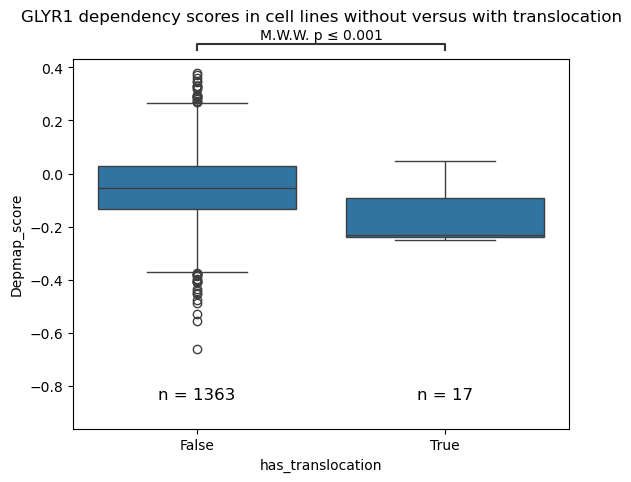

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.435e-07 U_stat=2.110e+04


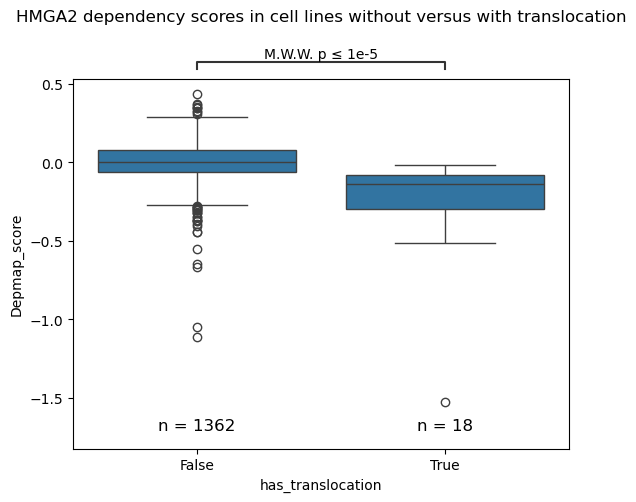

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.520e-08 U_stat=1.500e+04


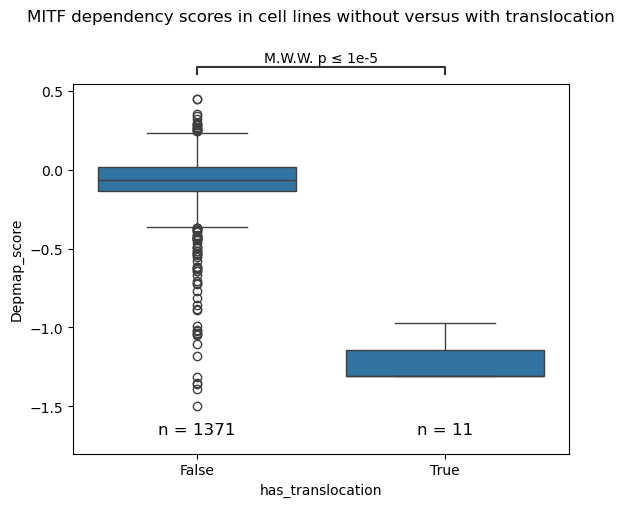

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.101e-06 U_stat=9.508e+03


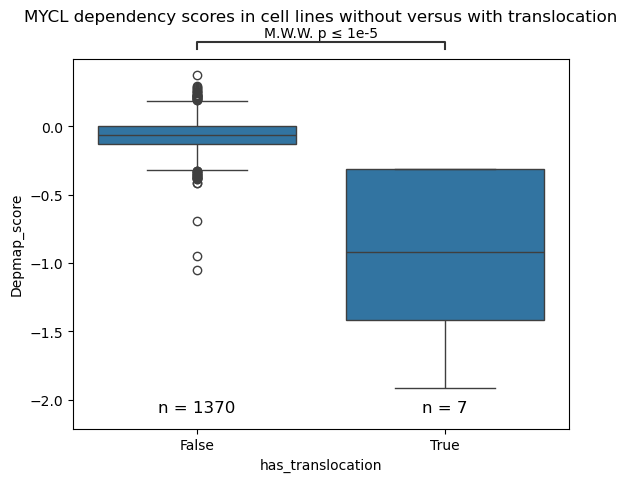

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.033e-03 U_stat=8.239e+03


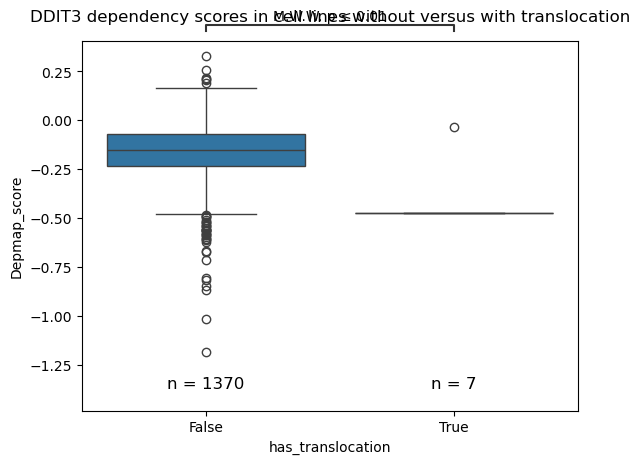

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.275e-07 U_stat=5.840e+03


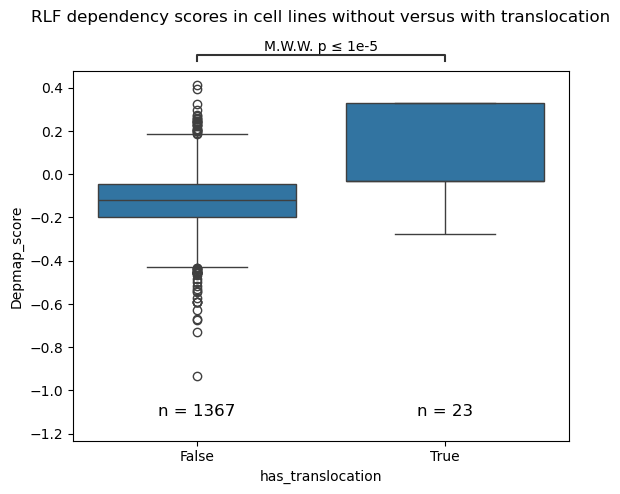

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.717e-05 U_stat=9.079e+03


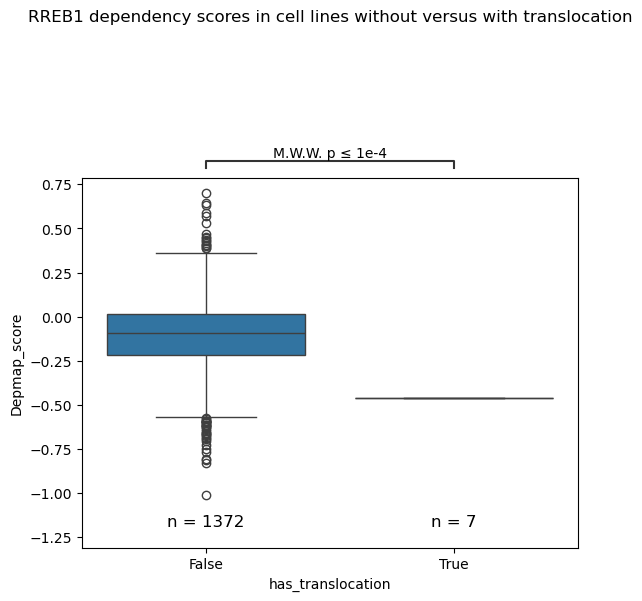

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.429e-04 U_stat=7.517e+03


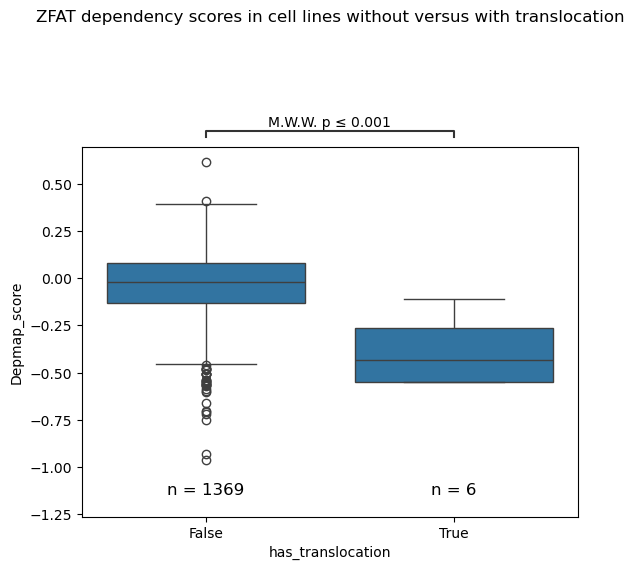

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.931e-05 U_stat=9.730e+02


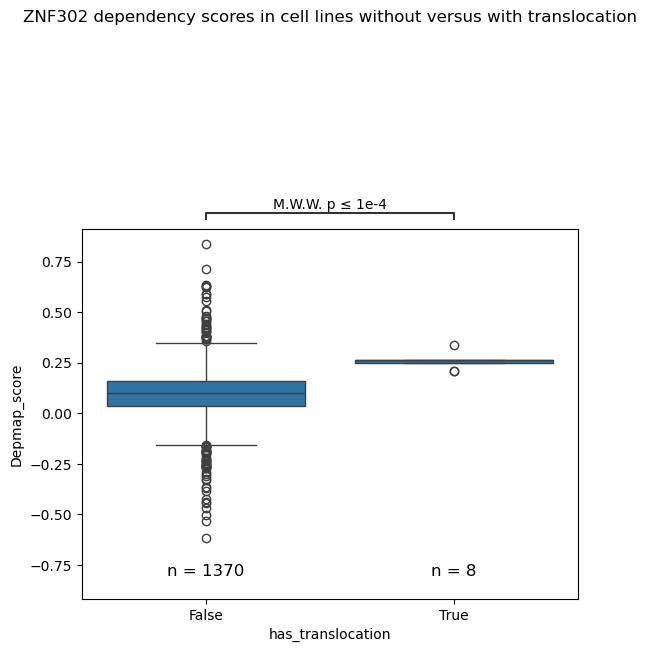

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.934e-05 U_stat=2.100e+02


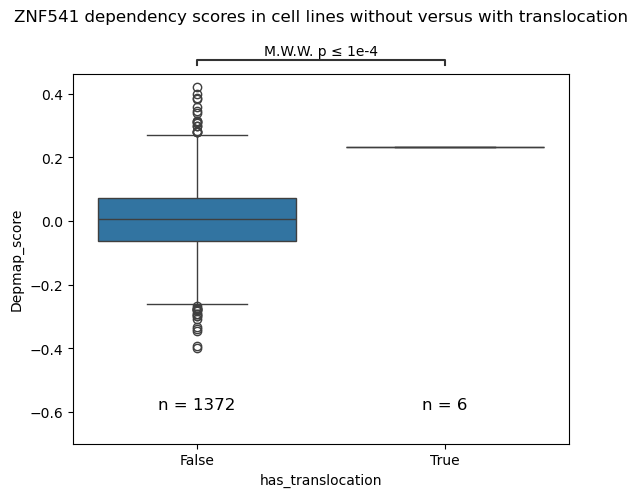

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.981e-04 U_stat=1.121e+04


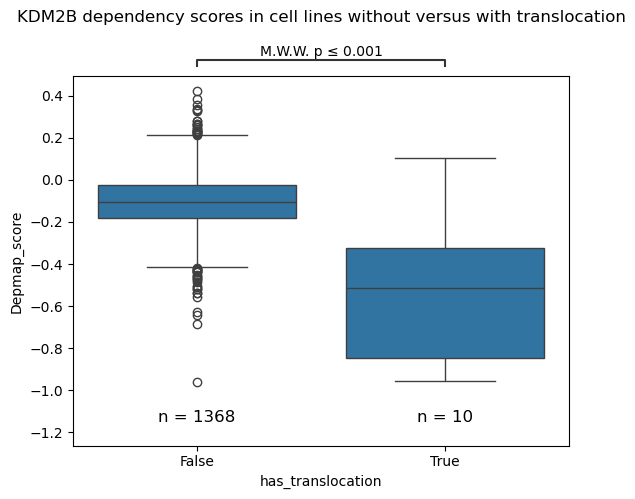

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.485e-08 U_stat=4.421e+04


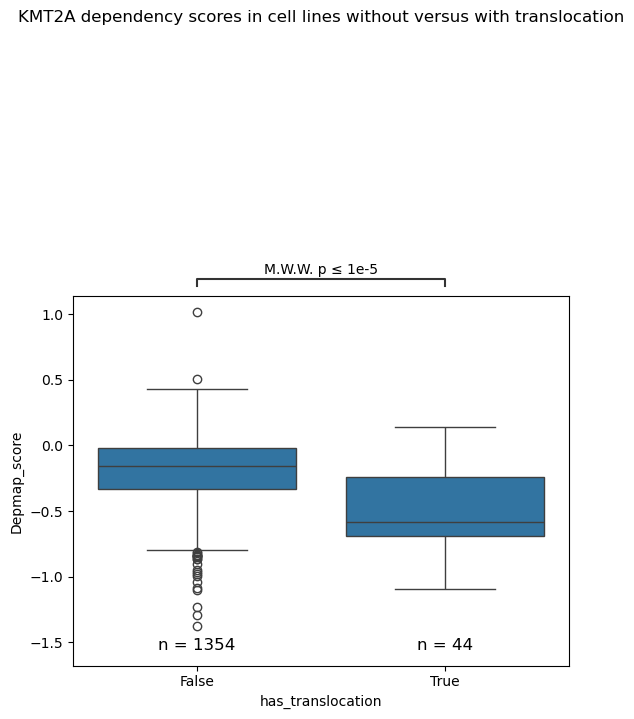

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.369e-05 U_stat=1.001e+04


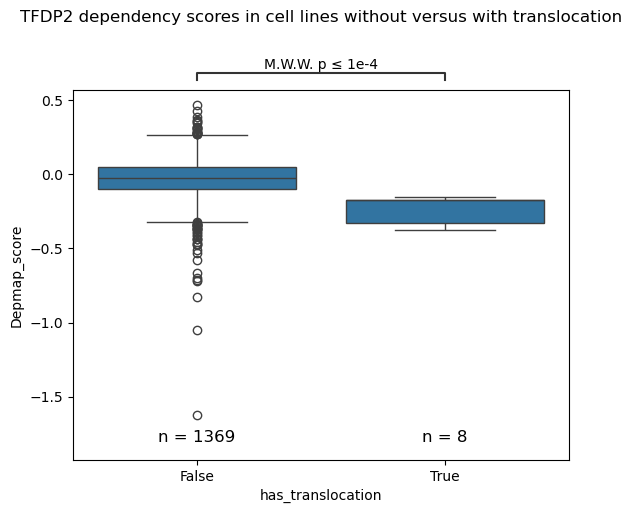

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.468e-14 U_stat=3.303e+04


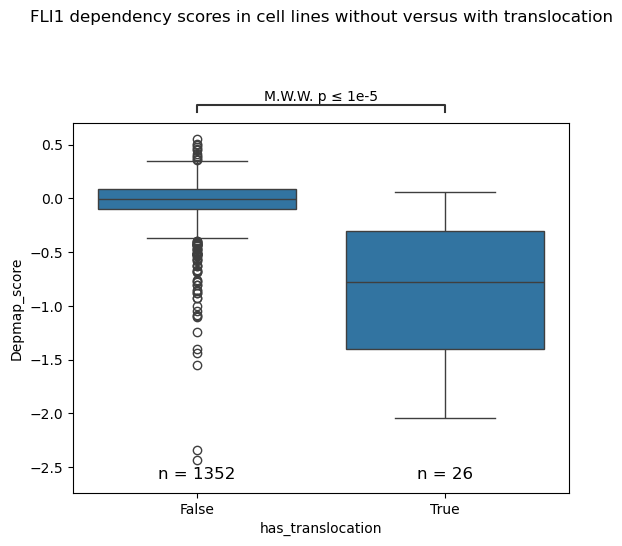

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.573e-06 U_stat=1.286e+04


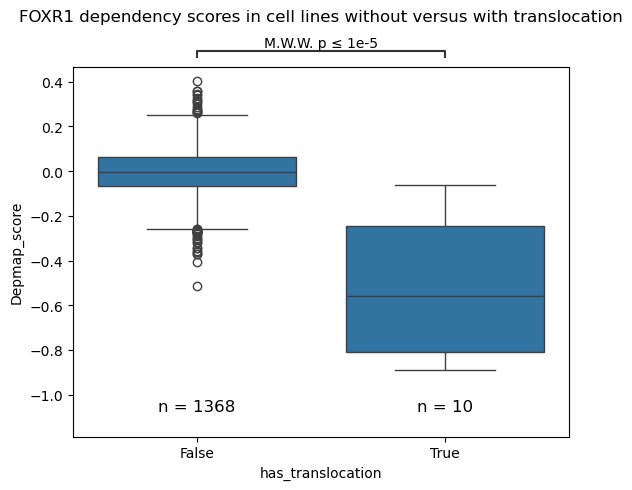

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.782e-05 U_stat=1.293e+04


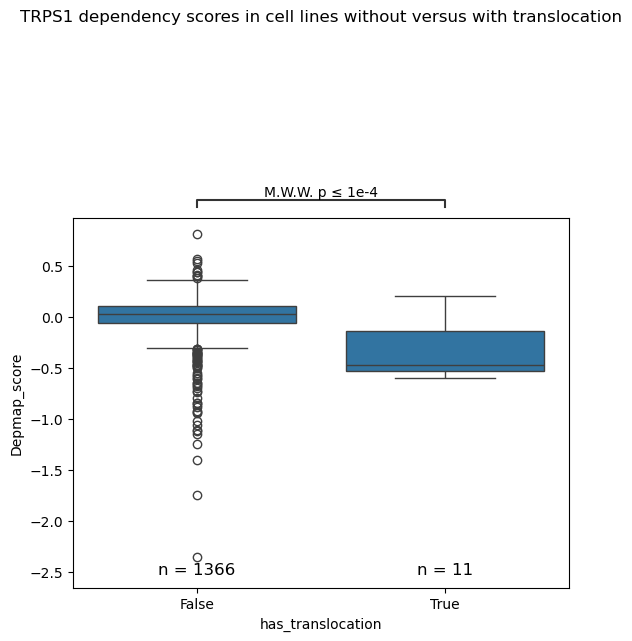

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.186e-04 U_stat=7.548e+03


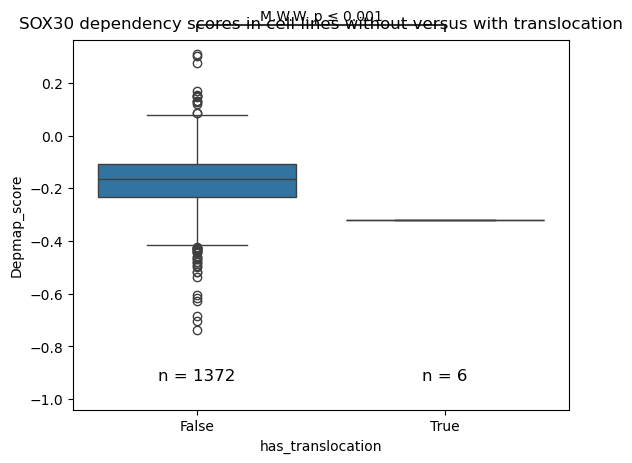

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.028e-05 U_stat=9.899e+03


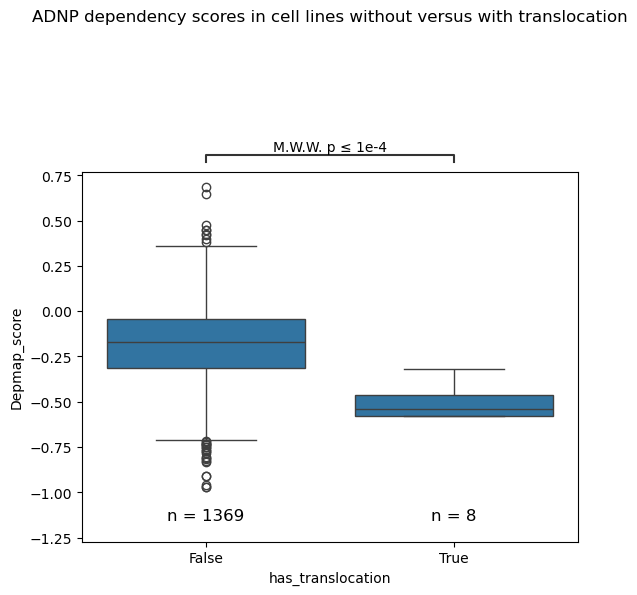

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.136e-06 U_stat=1.259e+04


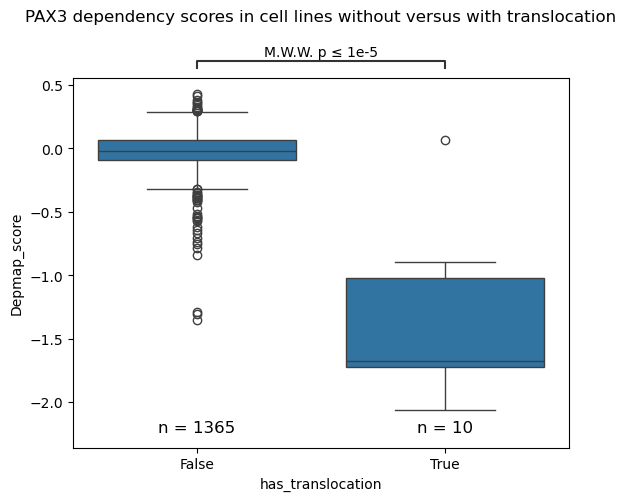

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.197e-03 U_stat=8.552e+03


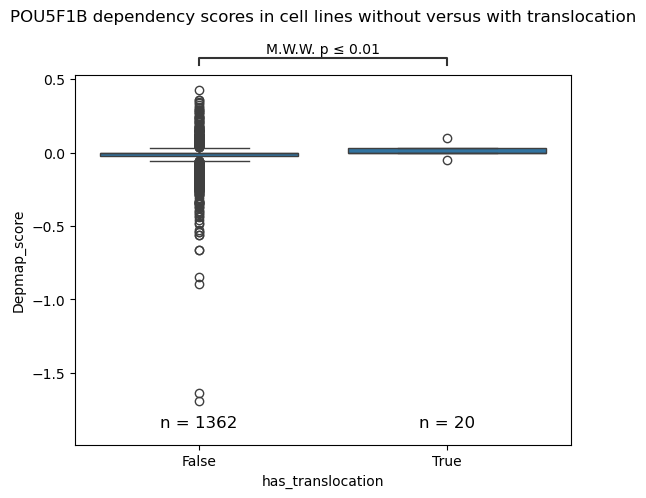

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.424e-07 U_stat=1.215e+04


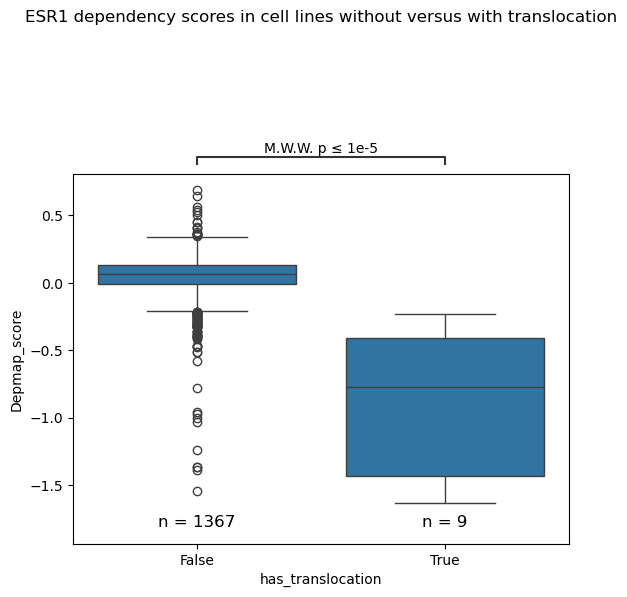

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.678e-24 U_stat=5.092e+04


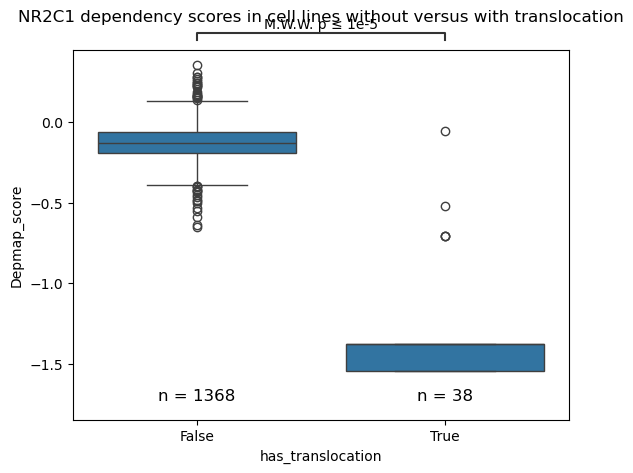

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.859e-05 U_stat=1.450e+04


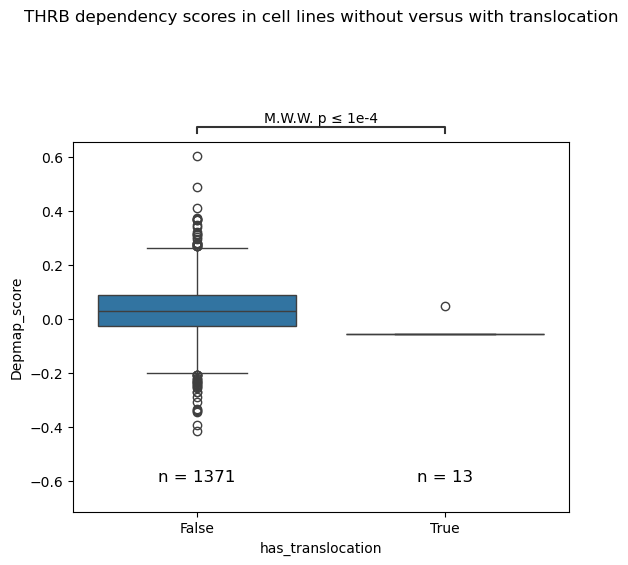

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.065e-04 U_stat=1.297e+04


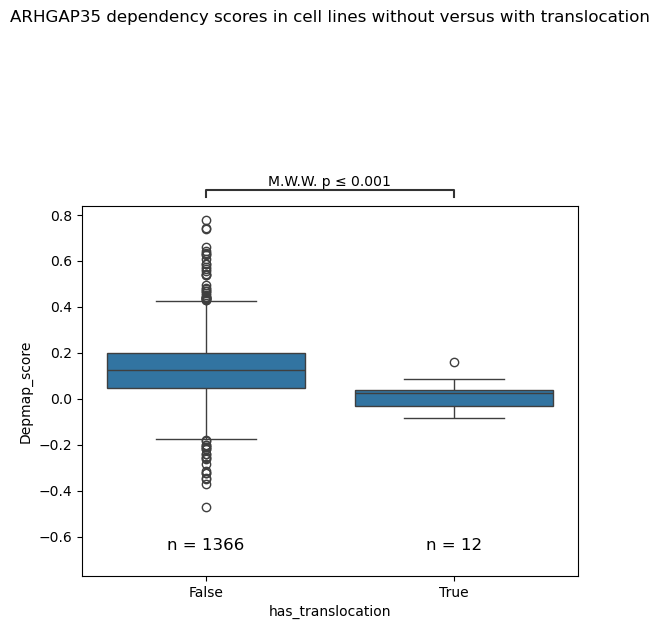

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.428e-04 U_stat=7.317e+03


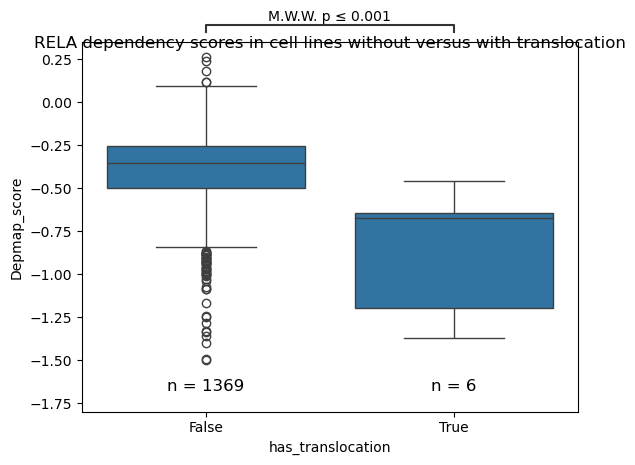

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.559e-05 U_stat=2.518e+04


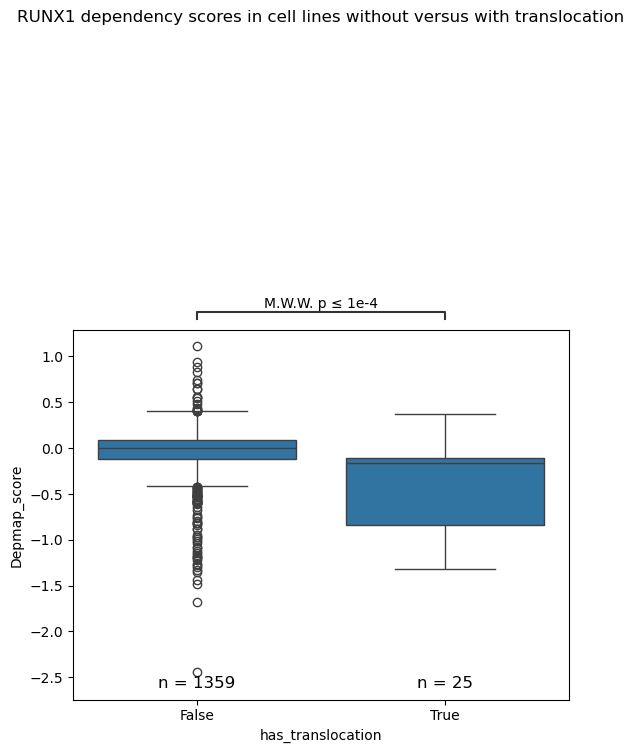

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.156e-09 U_stat=5.819e+04


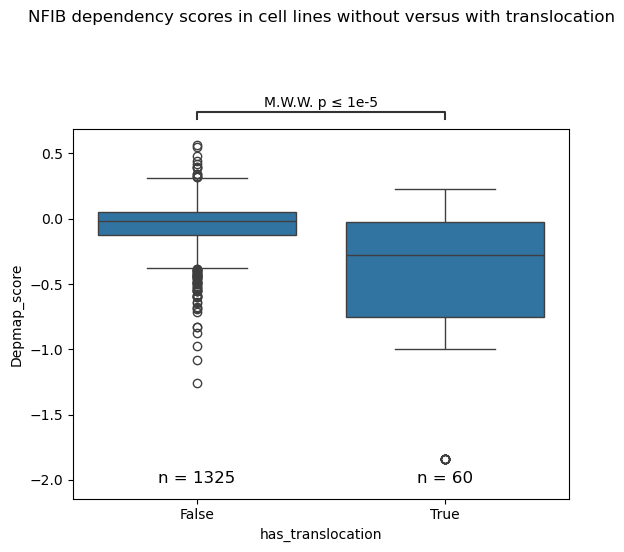

In [50]:
for tf in adjusted_tf_translocation_pvalues[p_adjusted < 0.1].TF:
    make_boxplot(tf)

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.512e-86 U_stat=4.556e+09


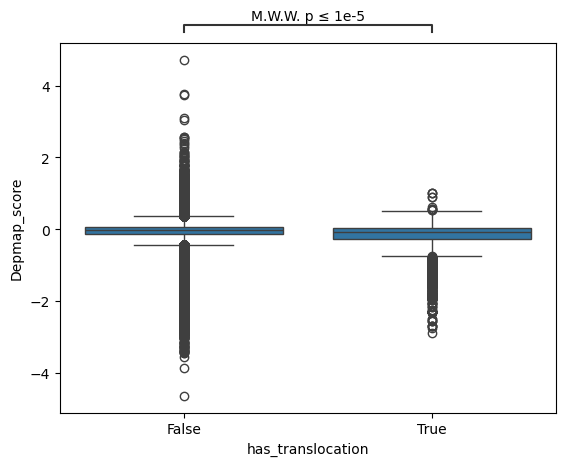

In [51]:
# also make a boxplot of dependencies across all TFs depending on whether they participate in translocations or not
#boxplot = sns.boxplot(filtered_df, x = 'has_translocation', y = 'Depmap_score')
boxplot = sns.boxplot(dependencies_translocations_df_side_a, x = 'has_translocation', y = 'Depmap_score')
pairs = [(True, False)]
annotator = Annotator(boxplot, pairs, data=dependencies_translocations_df_side_a, x='has_translocation', y='Depmap_score')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='outside')
annotator.apply_and_annotate()
plt.show()

In [80]:
# make boxplots of dependencies for any TF in cell lines with a translocation vs. without while specifying a specific lineage of interest
def make_boxplot_specific_lineage(tf, lineage):
    filtered_df = dependencies_translocations_df_side_a.loc[(dependencies_translocations_df_side_a['TF'] == tf) &
                                                            (dependencies_translocations_df_side_a['OncotreeLineage'] == lineage),:]
    no_translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.isna(), 'Depmap_score']
    translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']
    # Example using t-tests for comparing two groups
    t_test_results = {}
    # Check if groups are large enough to perform a t-test
    
    if len(no_translocation_scores) >= 3 and len(translocation_scores) >= 3:
        statistic, p_value = mannwhitneyu(no_translocation_scores, translocation_scores, alternative='two-sided')
        boxplot = sns.boxplot(filtered_df, x = 'has_translocation', y = 'Depmap_score')
        boxplot.set_title(f'{tf} dependency scores in cell lines without versus with translocation', 
                          y = (max(filtered_df.Depmap_score) + 1))
        pairs = [(True, False)]
        annotator = Annotator(boxplot, pairs, data=filtered_df, x='has_translocation', y='Depmap_score')
        annotator.configure(test='Mann-Whitney', text_format='simple', loc='outside')

        annotator.apply_and_annotate()
       # plt.text(1, max(filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']) + 0.3, f'p = {p_value:.3e}', ha='center', va='bottom', fontsize=12)
        plt.text(0, min(filtered_df.loc[:, 'Depmap_score']) - 0.2 , f'n = {no_translocation_scores.shape[0]}', ha='center', va='bottom', fontsize=12)
        plt.text(1, min(filtered_df.loc[:, 'Depmap_score']) - 0.2 , f'n = {translocation_scores.shape[0]}', ha='center', va='bottom', fontsize=12)
        plt.ylim(bottom = min(filtered_df.loc[:, 'Depmap_score']) - 0.3, top = None)
        plt.show()
    #else:
        #print("Not enough data")

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.606e-06 U_stat=5.320e+02


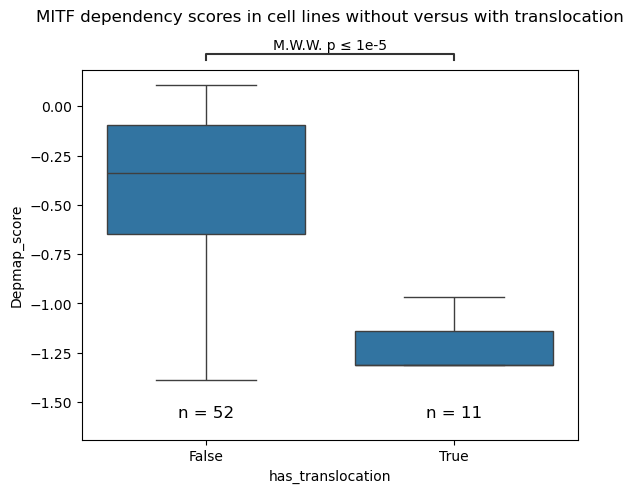

In [53]:
make_boxplot_specific_lineage('MITF', 'Melanoma')

In [70]:
lymphoid_translocations = dependencies_translocations_df_side_a.loc[
    (dependencies_translocations_df_side_a['OncotreeLineage'] == "Lymphoid") &
    (dependencies_translocations_df_side_a.tf_translocation_side_a.notna()), 'TF']


In [72]:
lymphoid_translocations.unique()

array(['ARID3A', 'ARID2', 'PHF21A', 'SETBP1', 'SRCAP', 'ZBED4', 'MYC',
       'NCOA3', 'NPAS1', 'SREBF1', 'SREBF2', 'TCF3', 'TCFL5', 'TFAP4',
       'TFEC', 'USF2', 'ATF3', 'ATF6', 'ATF6B', 'BACH2', 'CREB3L2',
       'JDP2', 'JUND', 'MAF', 'NFE2L1', 'XBP1', 'E4F1', 'GTF3A', 'HIC1',
       'IKZF1', 'IKZF2', 'MZF1', 'PRDM1', 'PRDM2', 'REPIN1', 'YY1',
       'ZBTB11', 'ZBTB20', 'ZBTB38', 'ZBTB7A', 'ZFP62', 'ZNF219', 'ZNF22',
       'ZNF264', 'ZNF267', 'ZNF346', 'ZNF410', 'ZNF438', 'ZNF493',
       'ZNF527', 'ZNF557', 'ZNF567', 'ZNF589', 'ZNF609', 'ZNF629',
       'ZNF644', 'ZNF740', 'ZNF777', 'ZNF827', 'ZSCAN10', 'ZBTB24',
       'ZNF524', 'ZNF277', 'CAMTA2', 'LIN28B', 'CUX1', 'SATB1', 'DNMT1',
       'KMT2A', 'E2F2', 'TFDP1', 'TFDP2', 'EBF1', 'ELF1', 'ETS1', 'ETV6',
       'FLI1', 'GABPA', 'SPDEF', 'FOXJ2', 'FOXJ3', 'FOXK1', 'FOXN3',
       'FOXP2', 'GATA2', 'GATAD2A', 'LEF1', 'TCF7', 'ADNP', 'MEIS2',
       'NANOGNB', 'POU2F1', 'IRF2', 'MEF2C', 'MEF2D', 'BAZ2A', 'CDC5L',
       'MYBL2',

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.291e-01 U_stat=3.270e+02


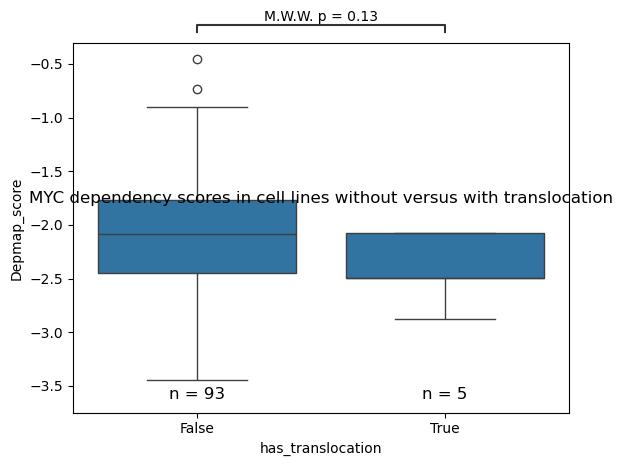

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.420e-01 U_stat=6.800e+01


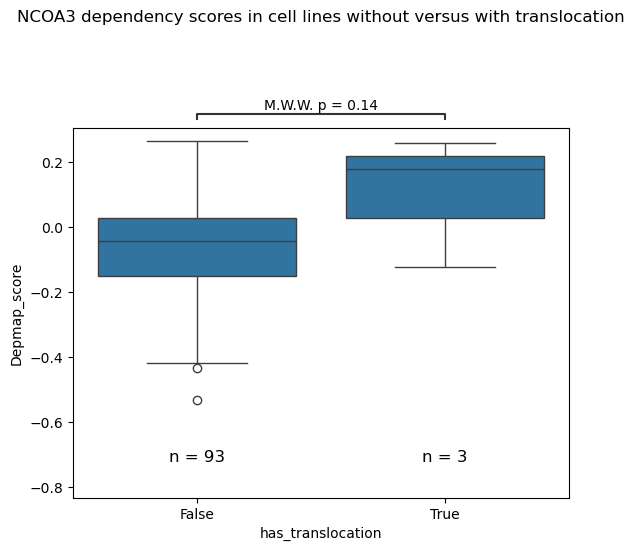

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.050e-02 U_stat=3.090e+02


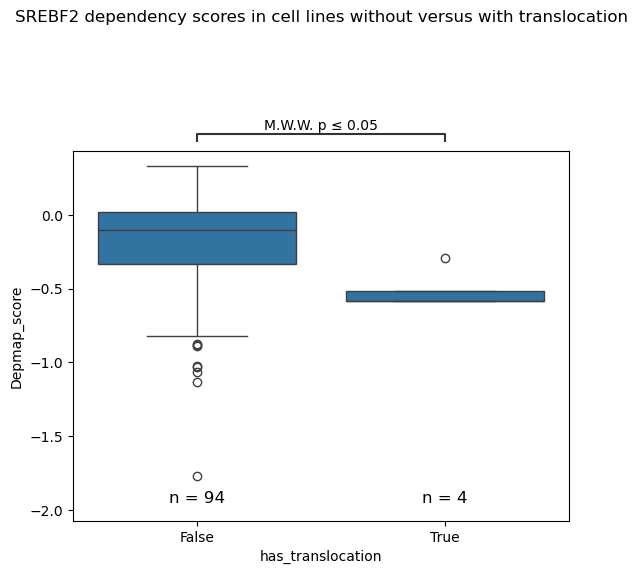

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.415e-03 U_stat=3.920e+02


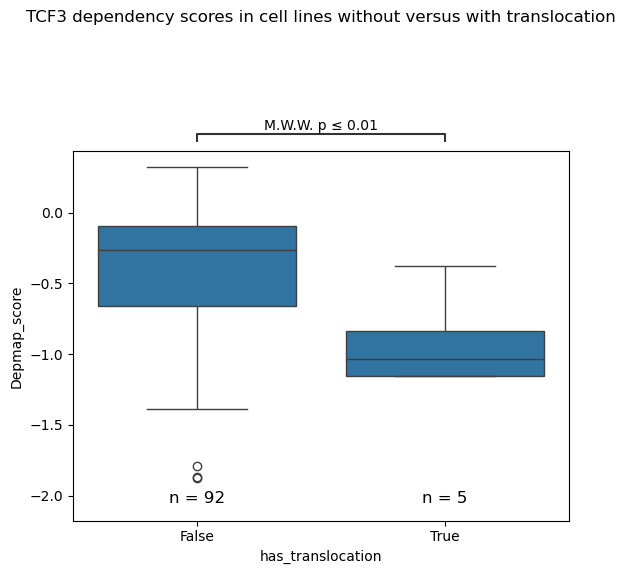

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.218e-02 U_stat=2.310e+02


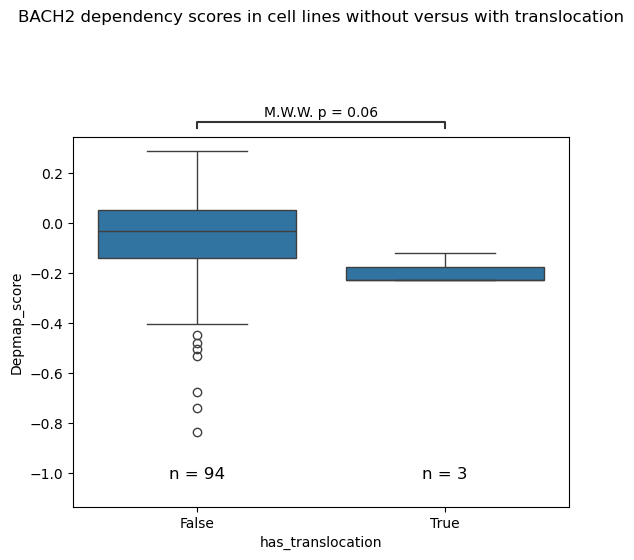

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.597e-01 U_stat=2.640e+02


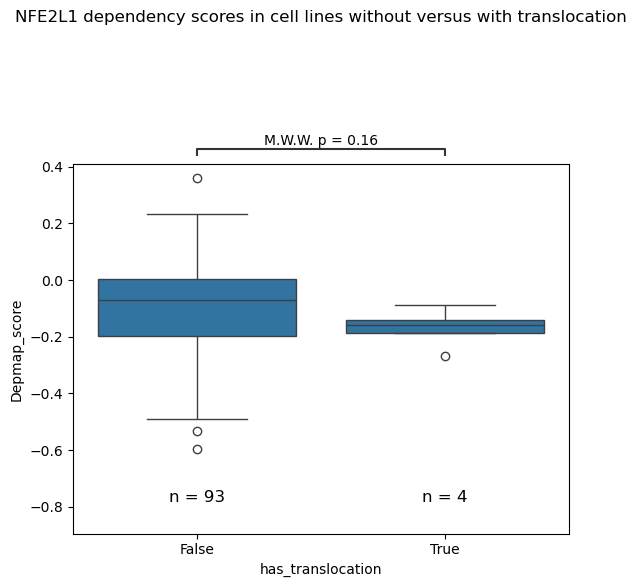

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.545e-02 U_stat=2.400e+02


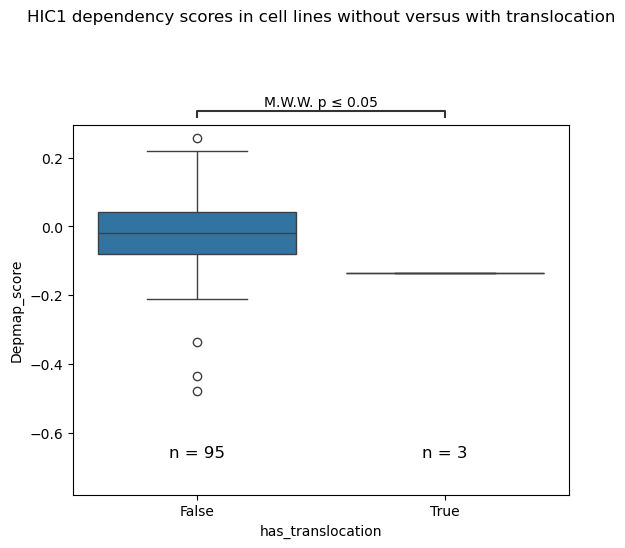

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.061e-01 U_stat=1.680e+02


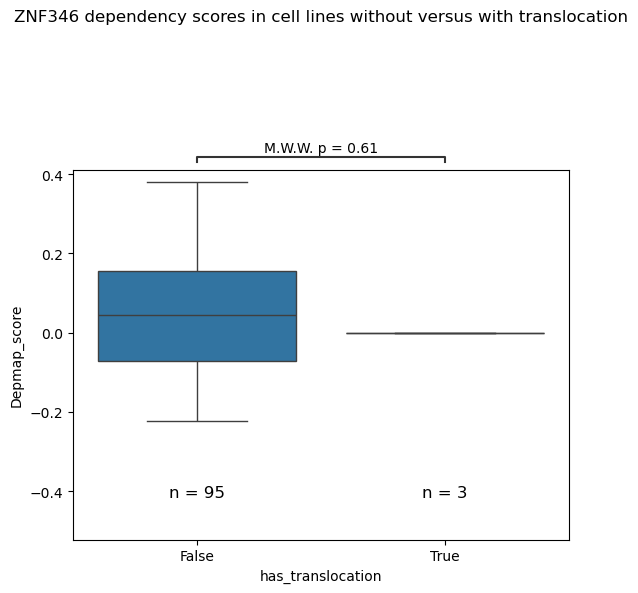

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.428e-01 U_stat=9.600e+01


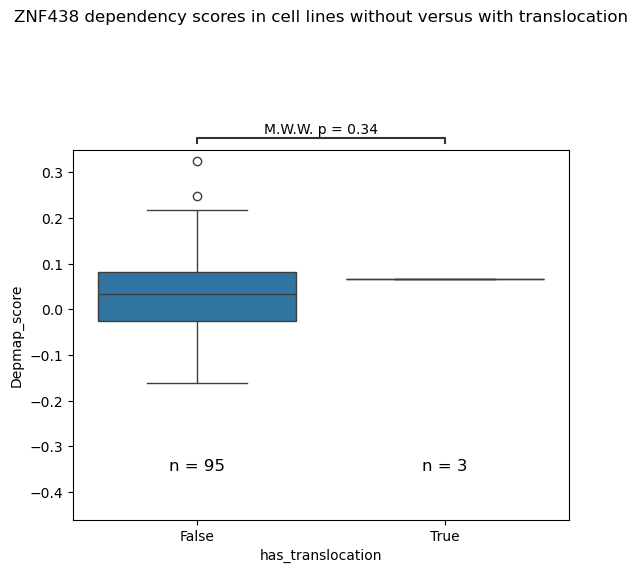

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.504e-02 U_stat=7.420e+02


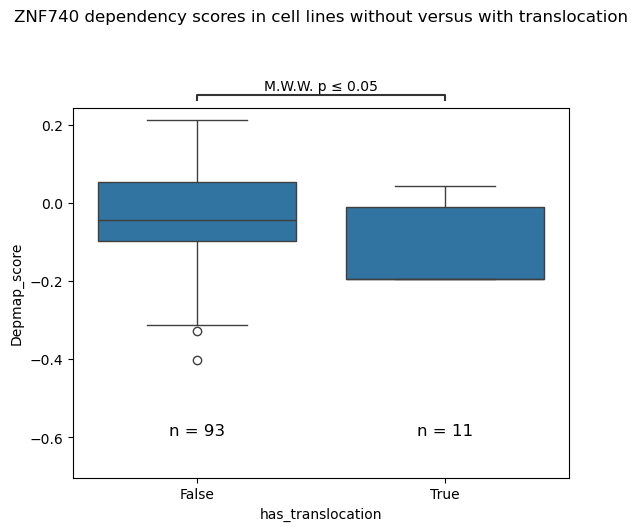

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.594e-02 U_stat=9.940e+02


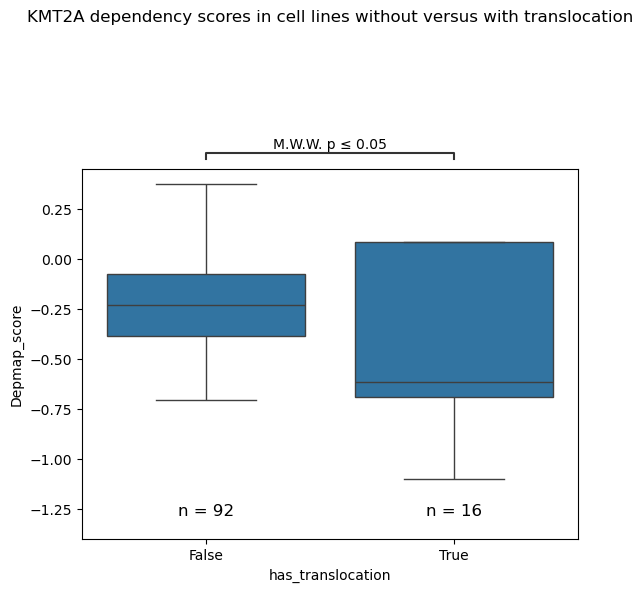

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.580e-01 U_stat=7.340e+02


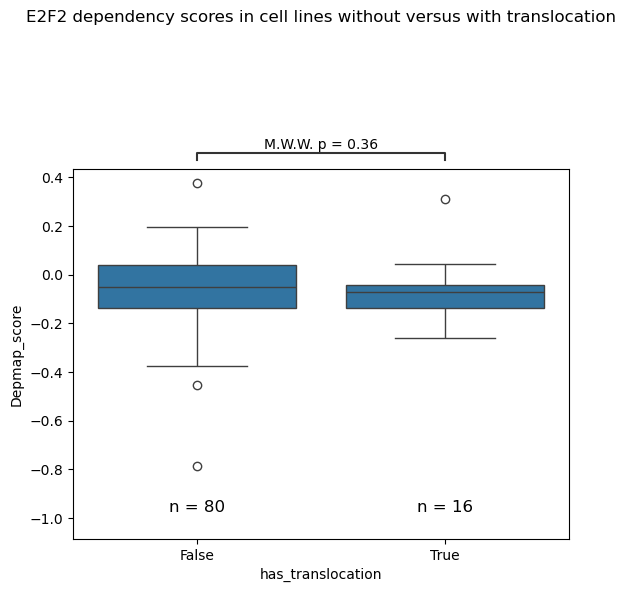

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.774e-01 U_stat=1.770e+02


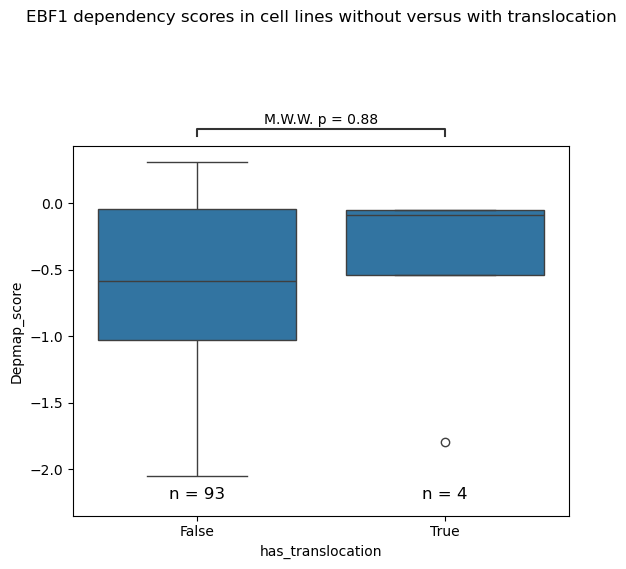

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.920e-01 U_stat=2.520e+02


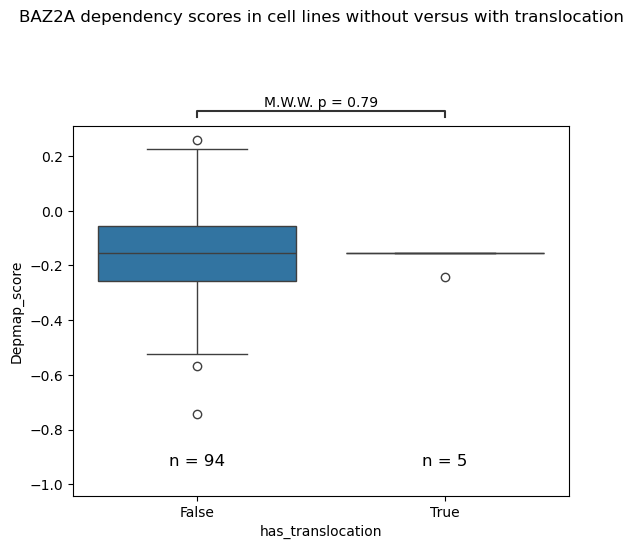

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.392e-01 U_stat=5.270e+02


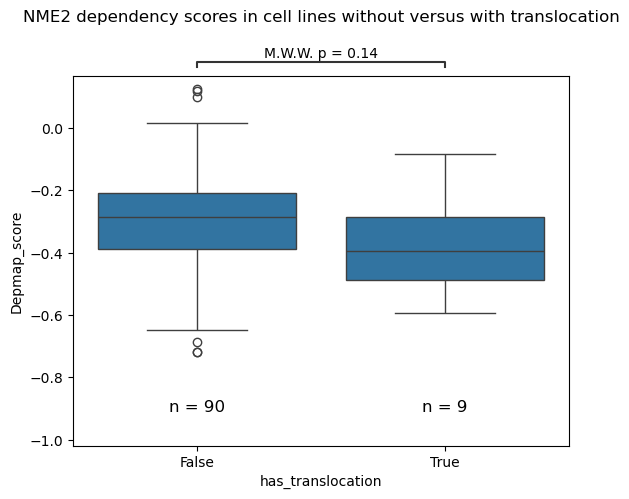

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.918e-02 U_stat=2.430e+02


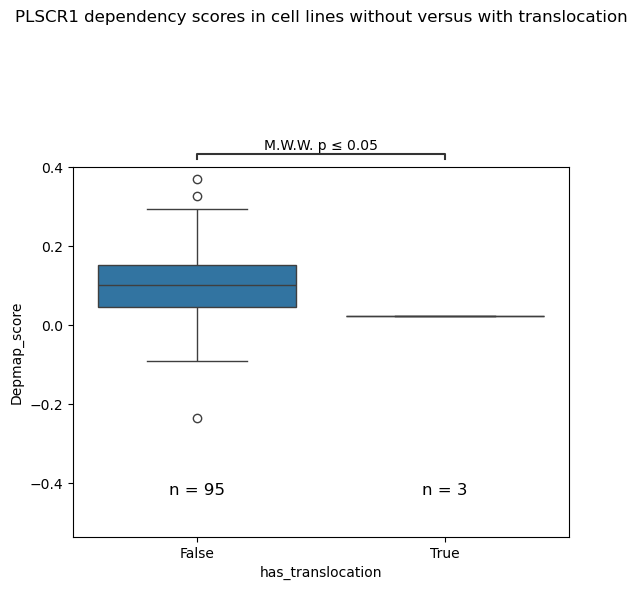

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.093e-03 U_stat=4.040e+02


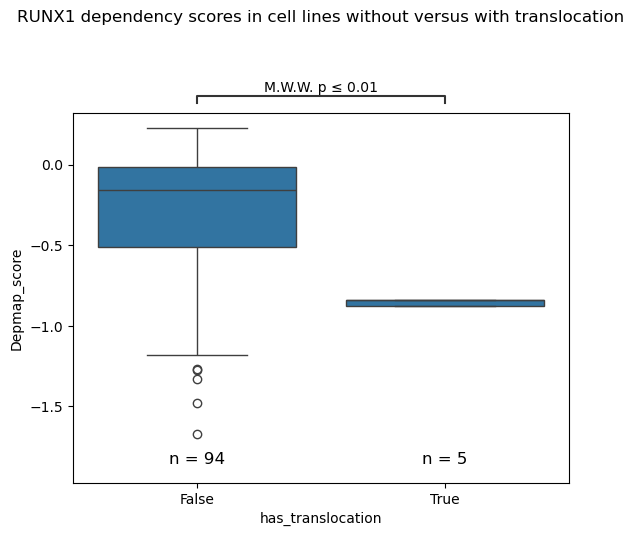

In [81]:
for tf in lymphoid_translocations.unique():
    make_boxplot_specific_lineage(tf, 'Lymphoid')

In [84]:
pd.Series(lymphoid_translocations.unique()).to_csv("pydata/lymphoid_translocations.csv", index=False)